In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/binary/"
chrom_set = ["chr1"]
input_length = 1000
fourier_att_prior_freq_limit = 200
fourier_att_prior_freq_limit_softness = 0.2
att_prior_grad_smooth_sigma = 3
task_index = None

In [25]:
# SPI1
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/binary/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1_keep1/11/model_ckpt_epoch_2.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior_keep1/26/model_ckpt_epoch_3.pt")

In [50]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/binary/config/GATA2/GATA2_training_paths.json")
num_tasks = 4
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2_keep1/6/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior_keep1/14/model_ckpt_epoch_3.pt")

In [59]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/binary/config/K562/K562_training_paths.json")
num_tasks = 1
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "K562_keep1/21/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior_keep1/29/model_ckpt_epoch_1.pt")

In [72]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/binary/config/BPNet_training_paths.json")
num_tasks = 3
task_index = 0
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "BPNet/22/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/16/model_ckpt_epoch_11.pt")

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [73]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [74]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [75]:
input_func = data_loading.get_binary_input_func(
    files_spec_path, input_length, reference_fasta
)
pos_bins = data_loading.get_positive_binary_bins(
    files_spec_path, task_ind=task_index, chrom_set=chrom_set
)

### Shap explainer
Create DeepSHAP explainers

In [76]:
noprior_shap_explainer = compute_shap.create_binary_explainer(
    noprior_model, input_length, task_index=task_index
)

In [77]:
prior_shap_explainer = compute_shap.create_binary_explainer(
    prior_model, input_length, task_index=task_index
)

### Compute loss values over test set

In [78]:
# Sample a subset of bins randomly to compute predictions for
num_samples = 1000
sample_bins = pos_bins[np.random.choice(len(pos_bins), size=num_samples, replace=False)]

In [79]:
noprior_preds = compute_predictions.get_binary_model_predictions(                                              
    noprior_model, sample_bins, input_func,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


In [80]:
prior_preds = compute_predictions.get_binary_model_predictions(                                              
    prior_model, sample_bins, input_func,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


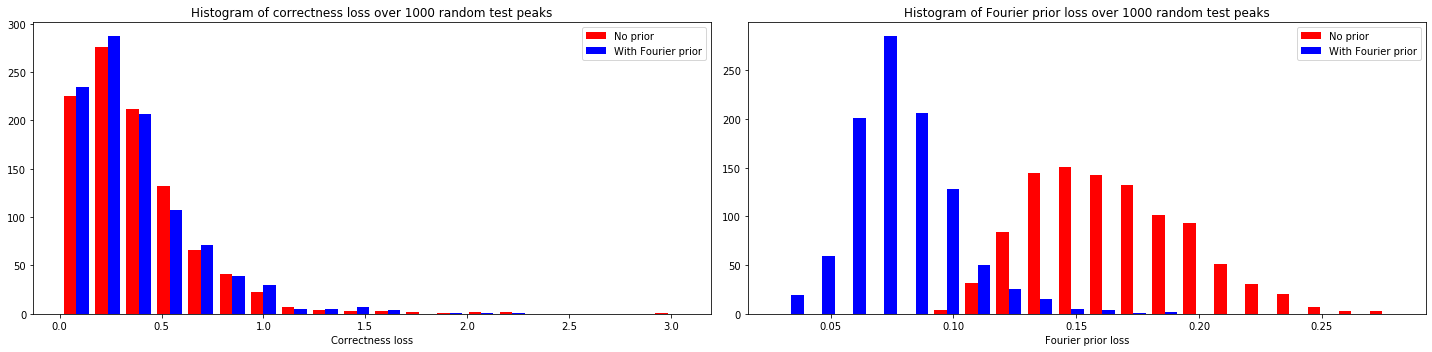

In [81]:
# Plot histogram of correctness loss and prior loss over these conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(
    [noprior_preds["corr_losses"], prior_preds["corr_losses"]],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
ax[0].set_title("Histogram of correctness loss over %d random test peaks" % len(sample_bins))
ax[0].set_xlabel("Correctness loss")
ax[0].legend()
ax[1].hist(
    [noprior_preds["att_losses"], prior_preds["att_losses"]],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
ax[1].set_title("Histogram of Fourier prior loss over %d random test peaks" % len(sample_bins))
ax[1].set_xlabel("Fourier prior loss")
ax[1].legend()
plt.tight_layout()

In [82]:
# The bins that show the most improvement in prior loss
sample_bins[np.flip(np.argsort(noprior_preds["att_losses"] - prior_preds["att_losses"]))][:10]

array([3025410, 3268070, 3346164, 3425614,  416401,  278610, 1548997,
       2751548, 1842276, 1572045])

### Plotting functions

In [20]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

def plot_fft(signal, include_dc=False, pos_limit=None, title=None):
    abs_signal = np.abs(signal)
    
    freqs, mags = dft(abs_signal)
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
        
    plt.figure(figsize=(20, 2))
    plt.plot(freqs, mags, color="red")
    plt.xlabel("Frequency (radians)")
    plt.ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(signal)
        plt.axvline(x=pos_limit_radians, color="black")
    if title:
        plt.title(title)
    plt.show()

In [21]:
def plot_signal(signal, title=None):
    plt.figure(figsize=(20, 2))
    plt.plot(signal)
    if title:
        plt.title(title)
    plt.show()

### View predictions

In [22]:
def predict_and_plot(model, shap_explainer, bin_index, show_sequences=True, seq_slice=slice(450, 550)):
    results = compute_predictions.get_binary_model_predictions(                                              
        model, np.array([bin_index]), input_func,                      
        return_losses=False, return_gradients=True, show_progress=False                                         
    )
    coords = results["coords"]
    input_seqs = results["input_seqs"]
    input_grads = results["input_grads"]

    chrom, start, end = coords[0]
    print("%s:%d-%d" % (chrom, start, end))
    
    if not seq_slice:
        seq_slice = slice(None, None)
    
    print("Input gradients and Fourier transform")
    plot_signal(np.sum(input_grads[0] * input_seqs[0], axis=1), title="Input gradients")
    plot_fft(np.sum(input_grads[0] * input_seqs[0], axis=1), pos_limit=200, title="Fourier transform of input gradients")
    if show_sequences:
        viz_sequence.plot_weights(input_grads[0][seq_slice])
        viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])
    
    print("SHAP scores")
    hyp_shap_scores = shap_explainer(input_seqs, hide_shap_output=True)
    plot_signal(np.sum(hyp_shap_scores[0] * input_seqs[0], axis=1), title="SHAP scores")
    if show_sequences:
        viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice])
        viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice])
    
    print("ISM scores")
    hyp_ism_scores = compute_ism.get_binary_model_ism(model, input_seqs, task_index=task_index)
    plot_signal(np.sum(hyp_ism_scores[0] * input_seqs[0], axis=1), title="ISM scores")
    if show_sequences:
        viz_sequence.plot_weights(hyp_ism_scores[0][seq_slice])
        viz_sequence.plot_weights((hyp_ism_scores[0] * input_seqs[0])[seq_slice])

In [102]:
# Sample some random peaks
pos_bins[np.random.choice(len(pos_bins), size=10, replace=False)]

array([1555161, 3640614,  779383, 2407477, 3030866, 2380924, 3832255,
       3087663, 2668849, 1299090])

chr1:182677150-182678150
Input gradients and Fourier transform


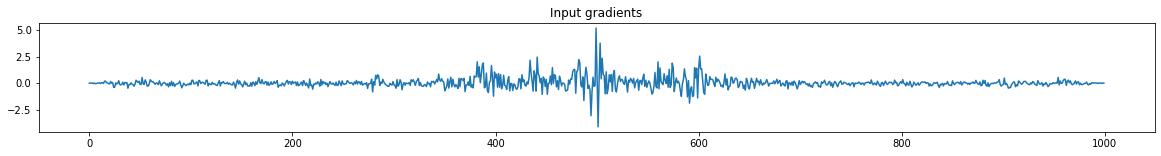

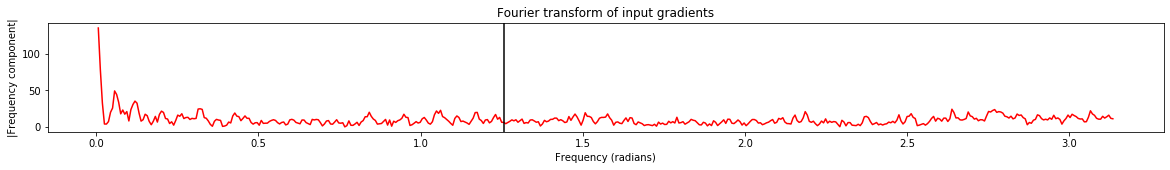

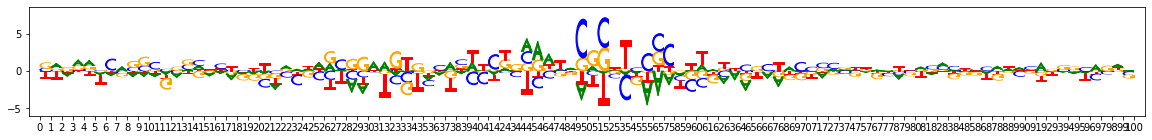

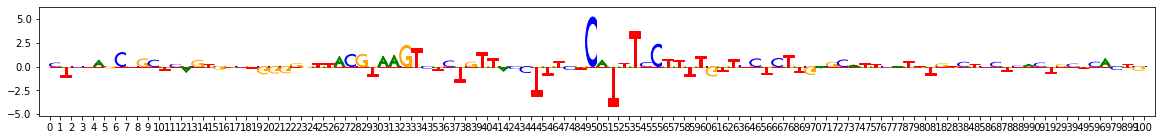

SHAP scores


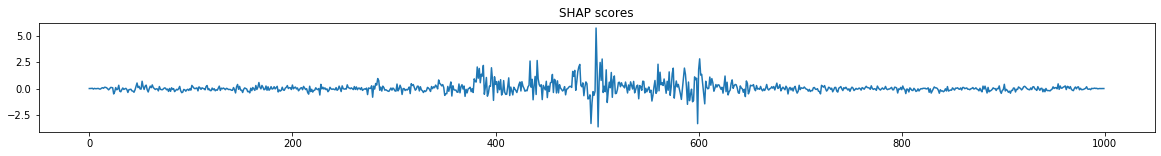

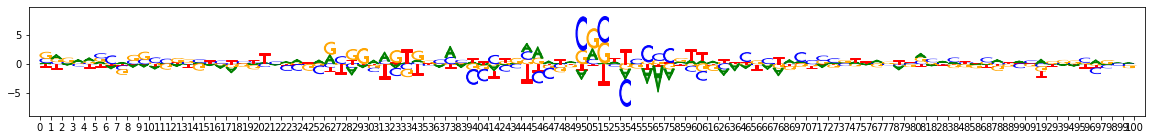

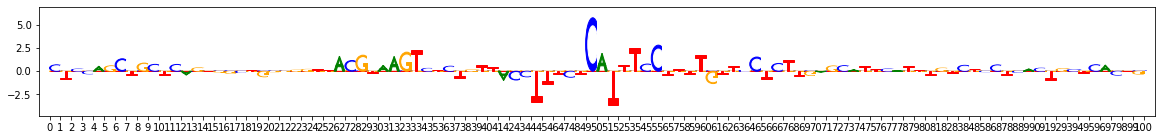

ISM scores


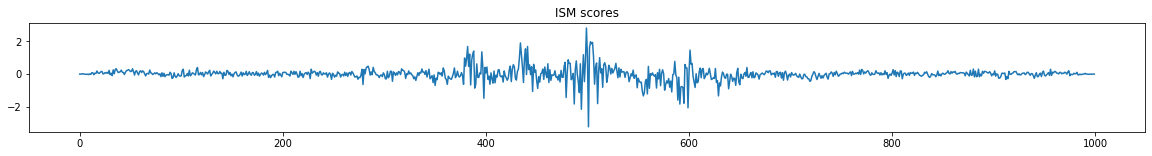

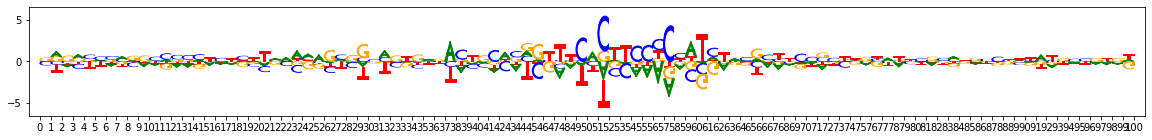

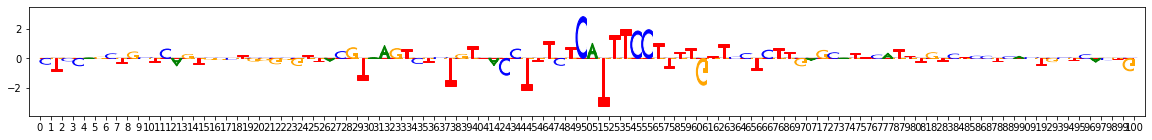

chr1:182677150-182678150
Input gradients and Fourier transform


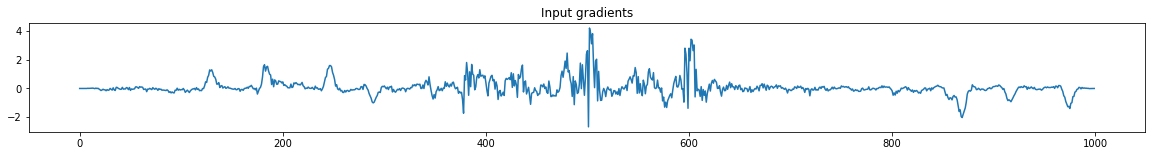

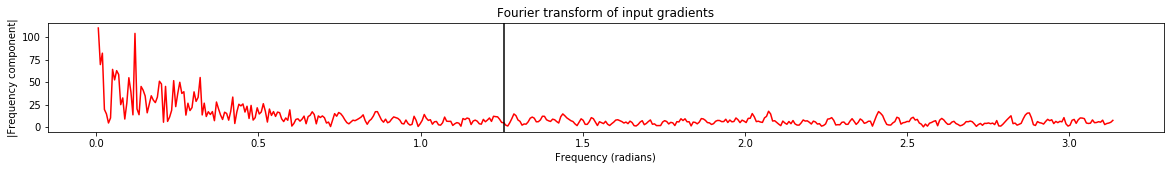

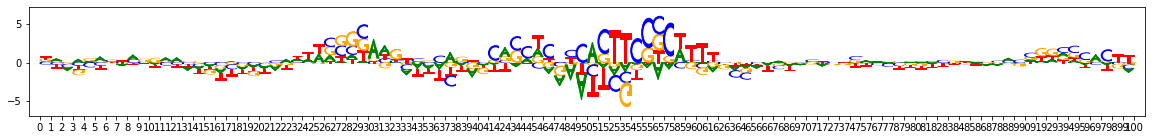

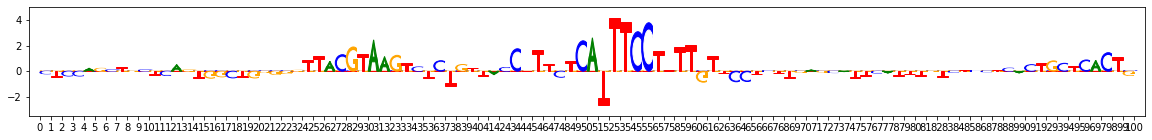

SHAP scores


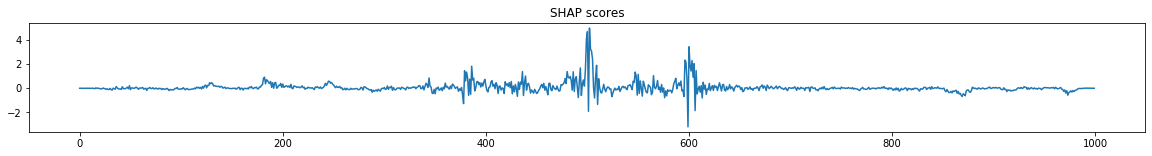

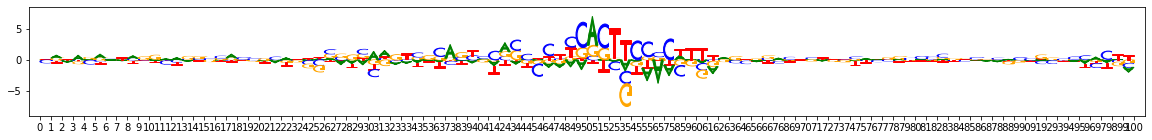

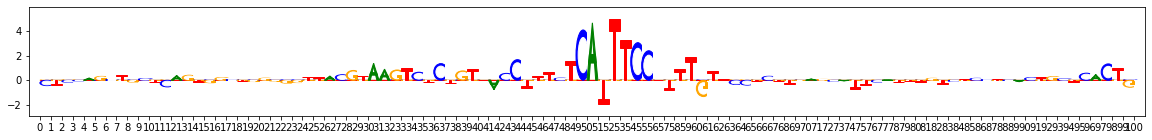

ISM scores


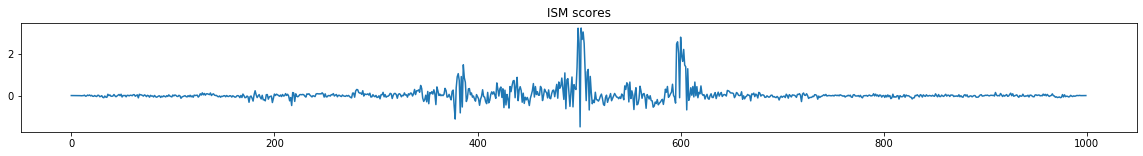

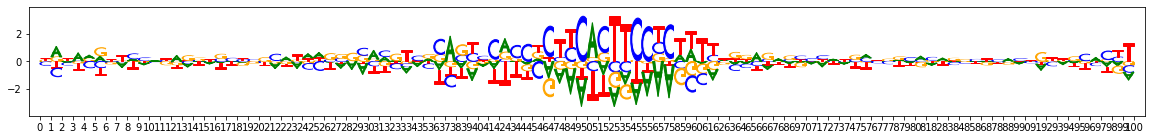

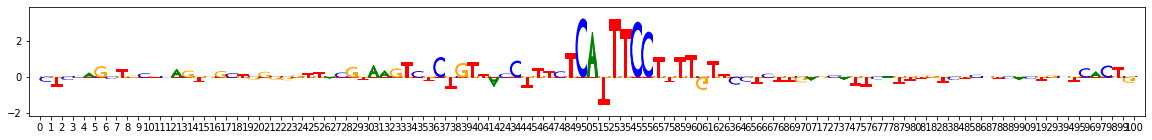

In [33]:
# SPI1
bin_index = 3653543
seq_slice = slice(450, 550)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, show_sequences, seq_slice)

chr1:230641650-230642650
Input gradients and Fourier transform


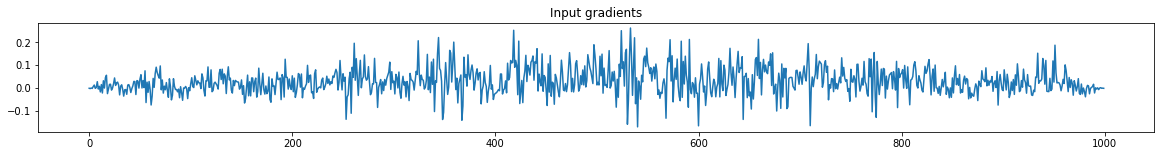

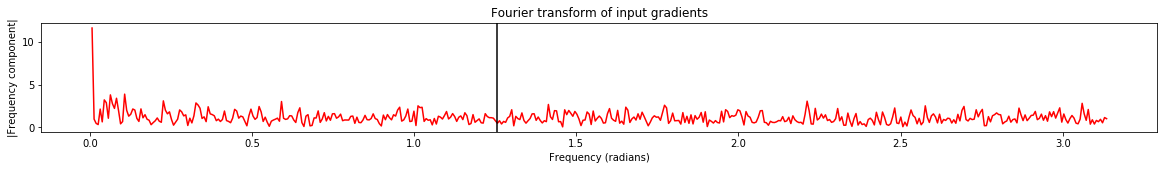

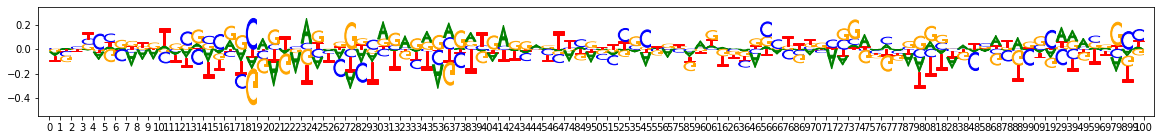

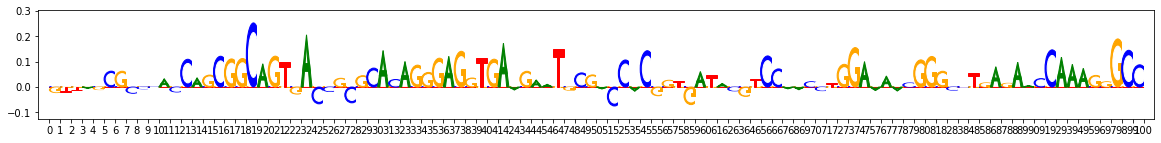

SHAP scores


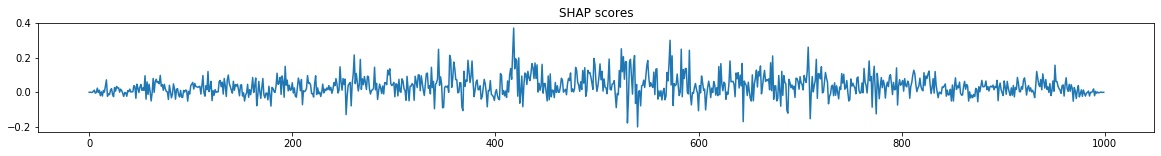

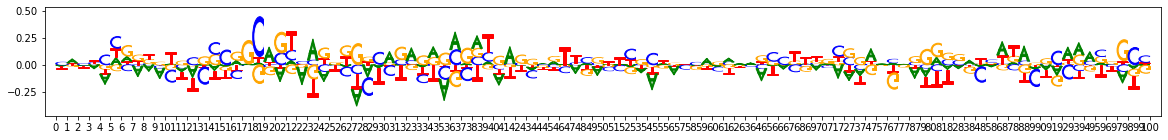

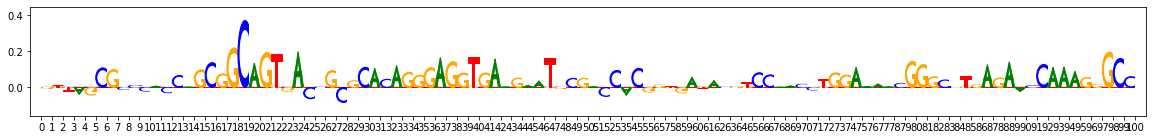

ISM scores


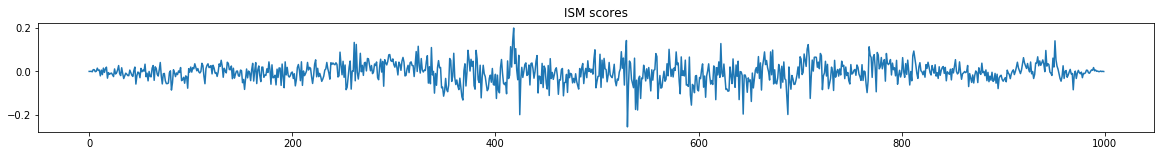

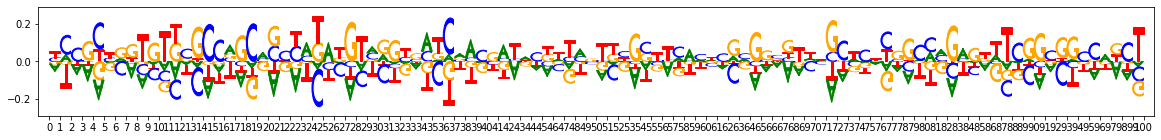

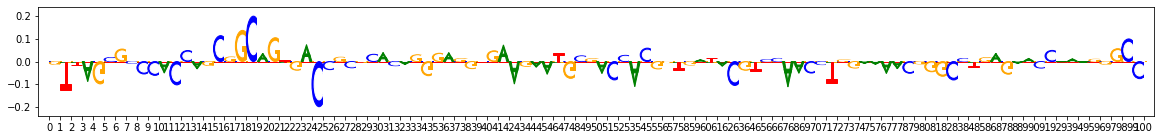

chr1:230641650-230642650
Input gradients and Fourier transform


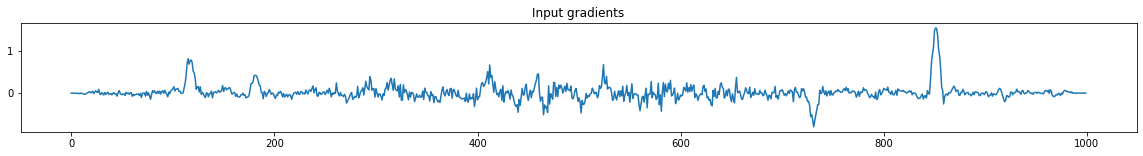

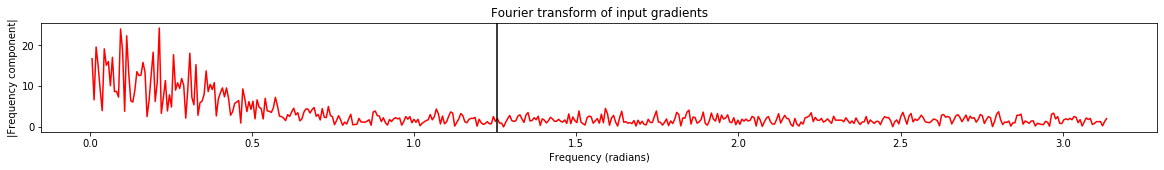

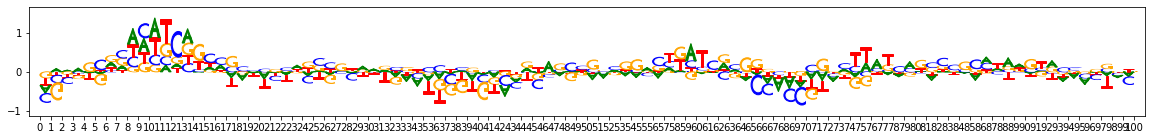

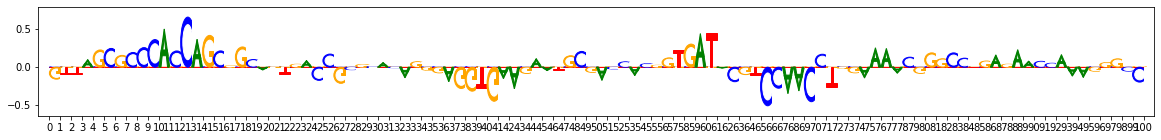

SHAP scores


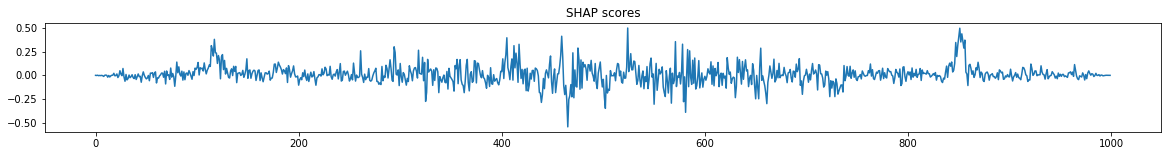

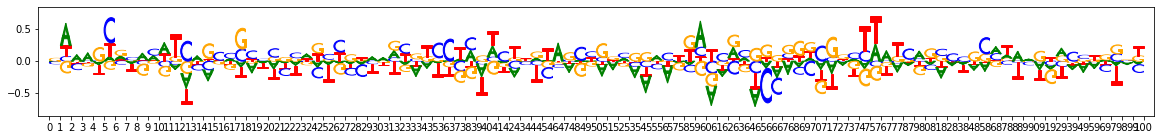

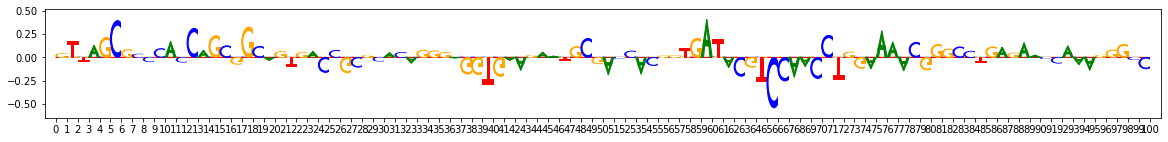

ISM scores


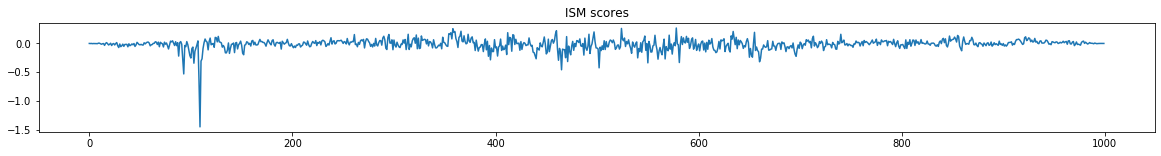

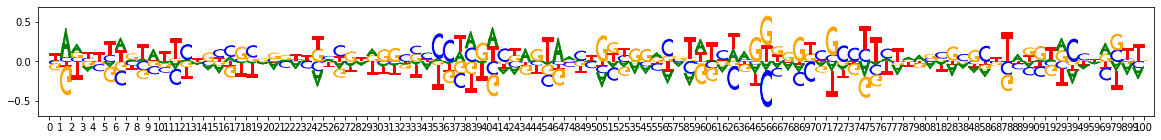

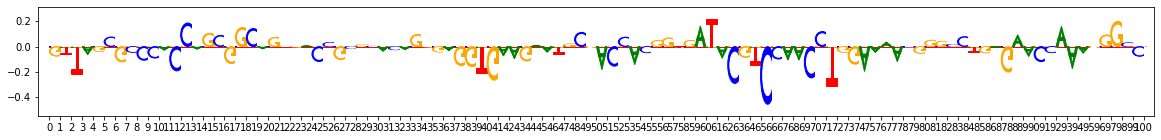

In [58]:
# GATA2
bin_index = 4612833
seq_slice = slice(400, 500)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, show_sequences, seq_slice)

chr1:2586450-2587450
Input gradients and Fourier transform


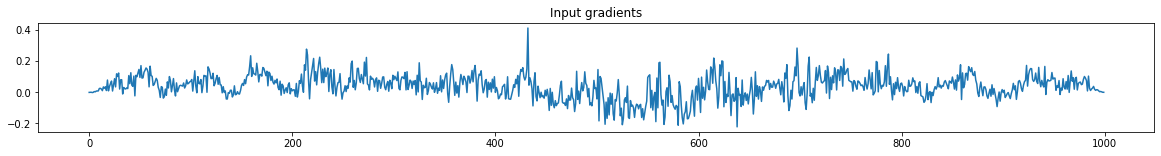

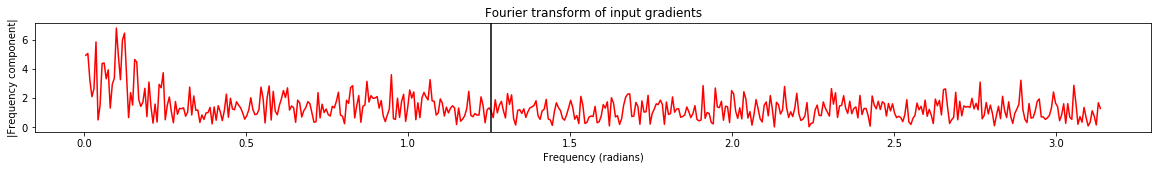

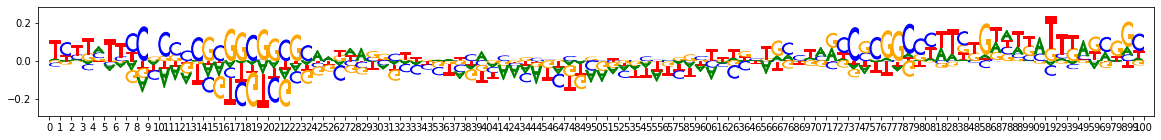

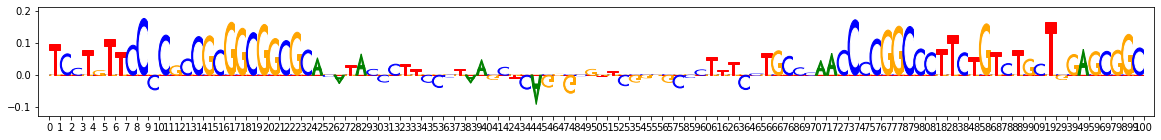

SHAP scores


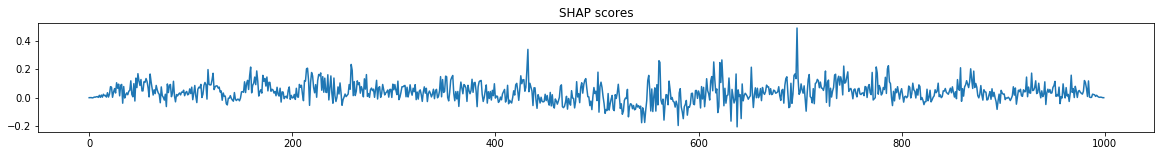

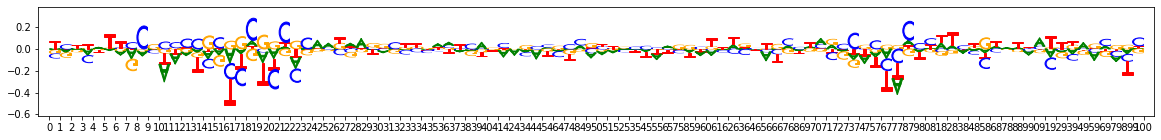

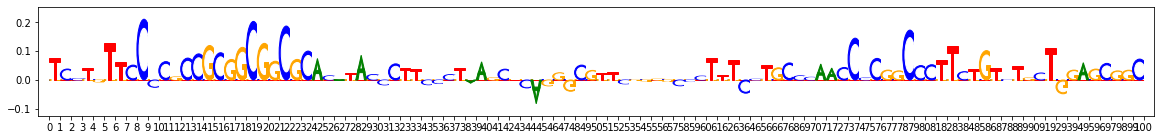

ISM scores


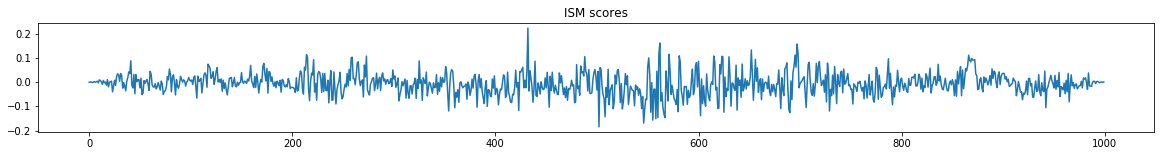

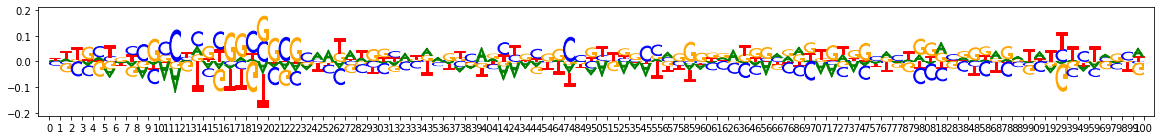

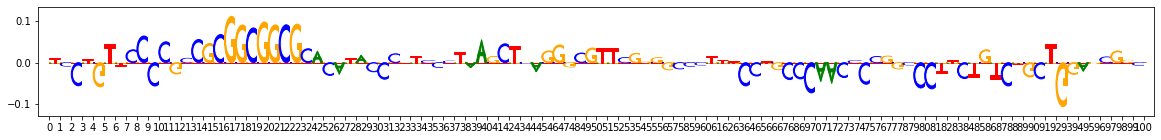

chr1:2586450-2587450
Input gradients and Fourier transform


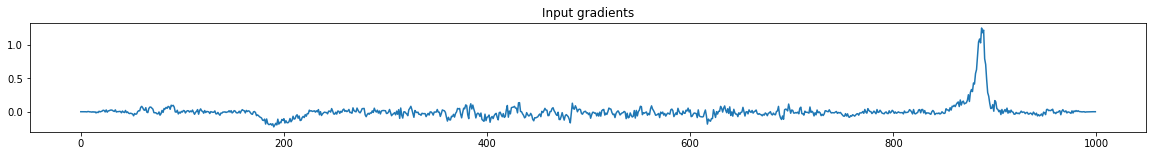

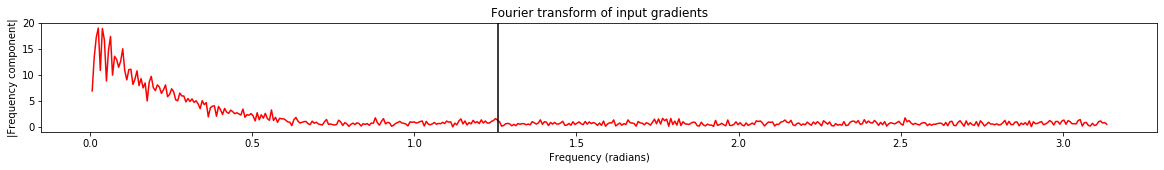

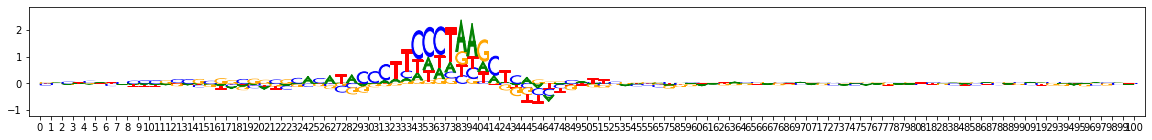

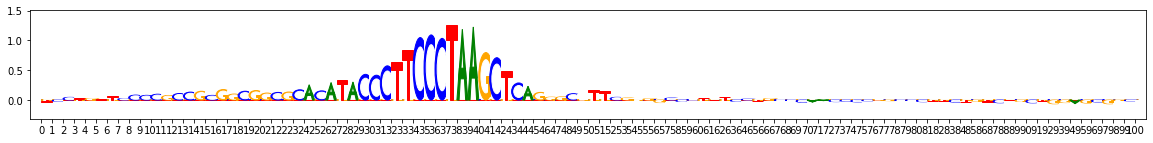

SHAP scores


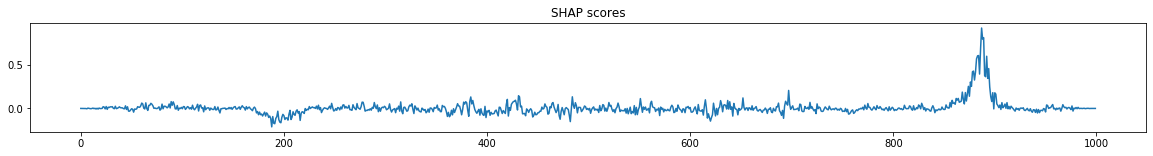

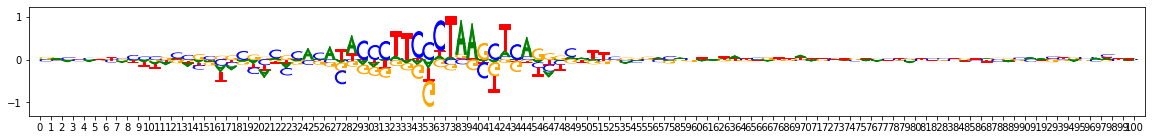

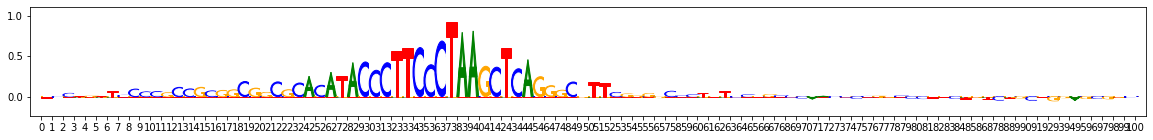

ISM scores


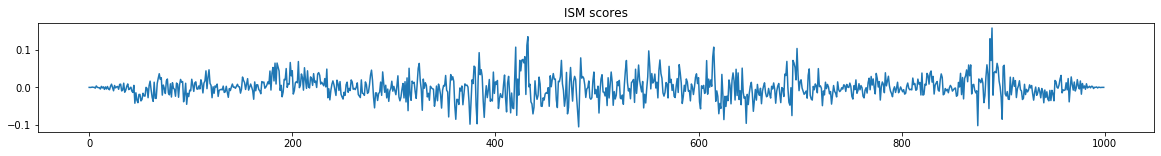

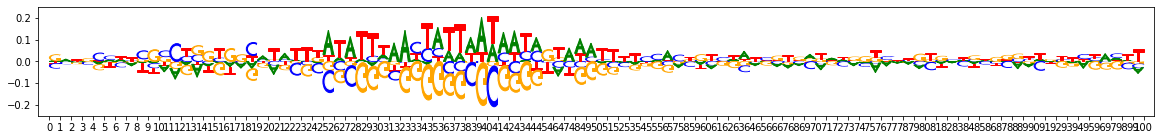

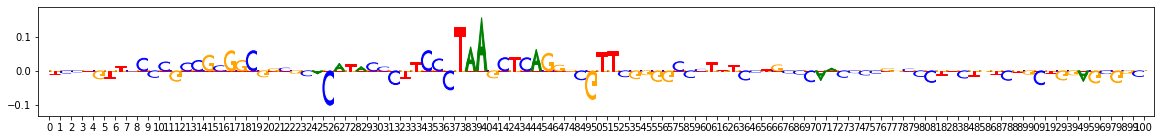

In [71]:
# K562
bin_index = 51729
seq_slice = slice(850, 950)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, show_sequences, seq_slice)

In [104]:
# Sample some random peaks
pos_bins[np.random.choice(len(pos_bins), size=10, replace=False)]

array([1151352, 3581378, 3536320, 2998255, 3874636, 3037563, 3733147,
       2390377,  790403,  283729])

chr1:149912750-149913750
Input gradients and Fourier transform


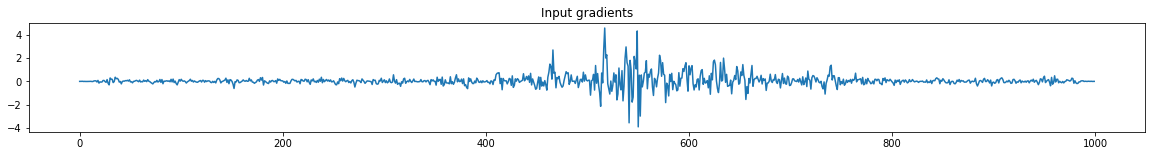

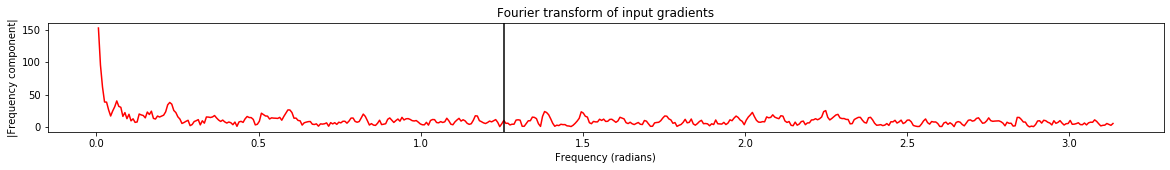

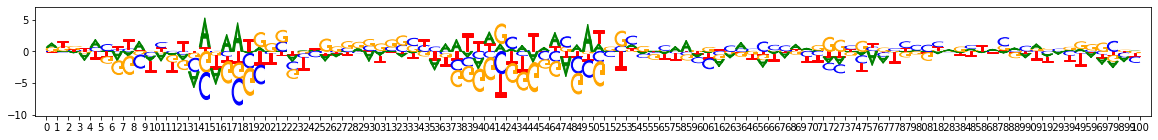

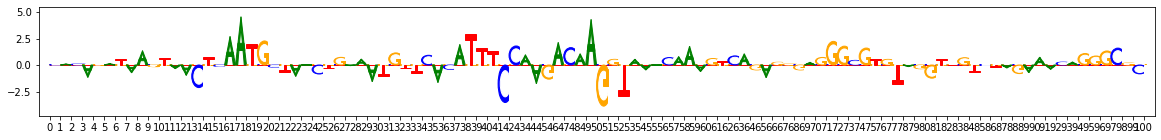

SHAP scores


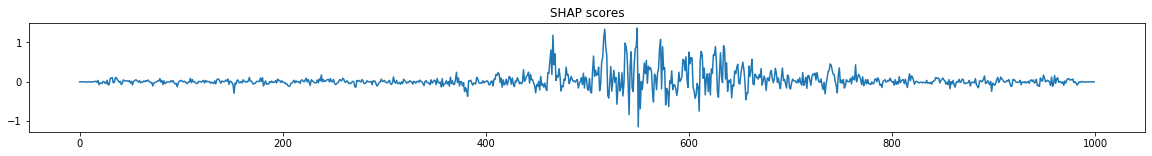

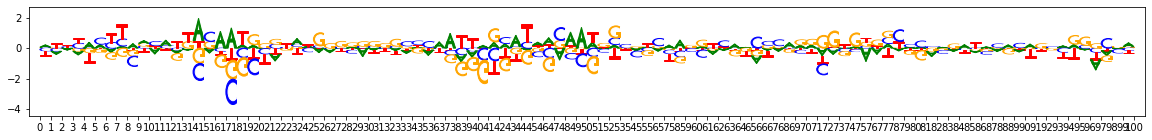

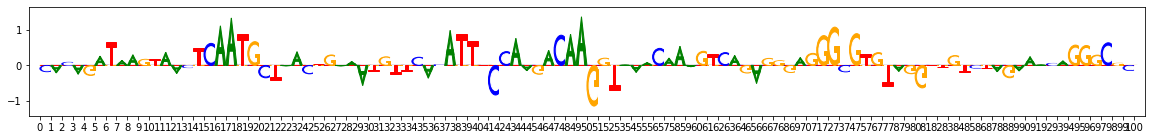

ISM scores


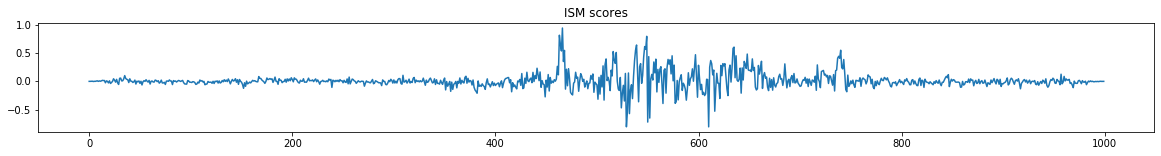

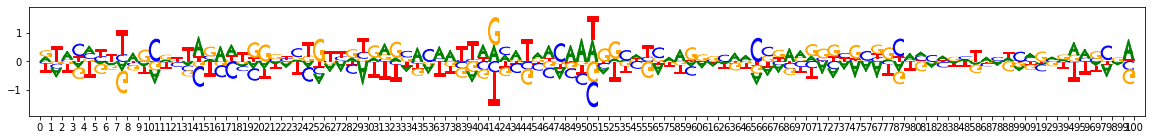

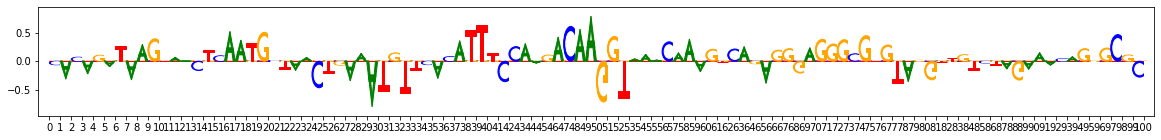

chr1:149912750-149913750
Input gradients and Fourier transform


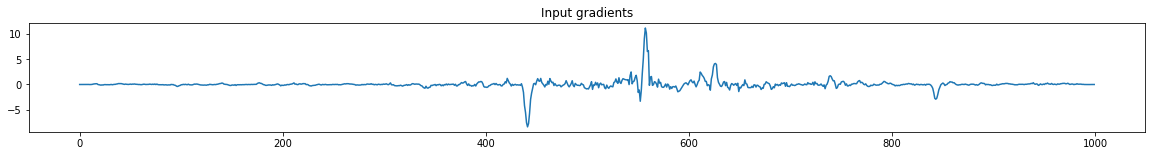

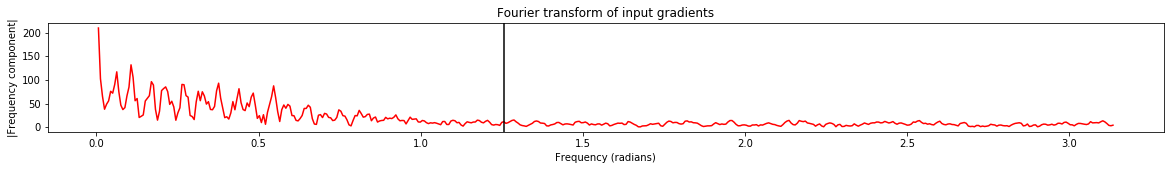

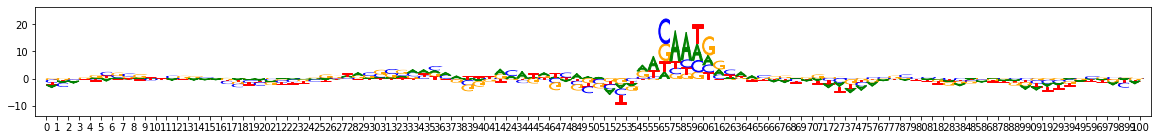

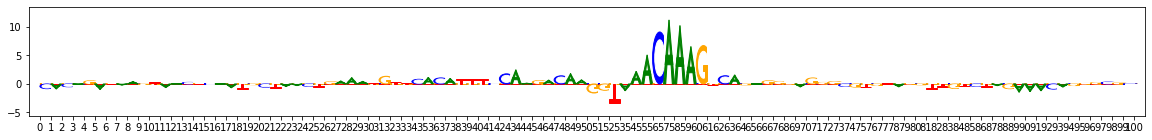

SHAP scores


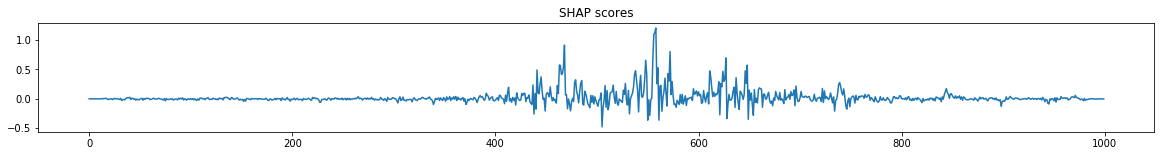

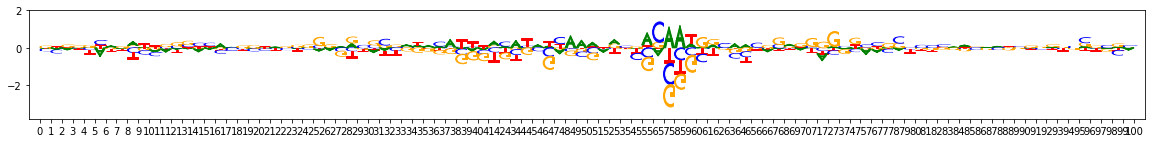

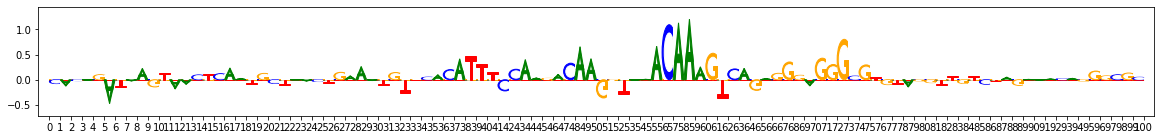

ISM scores


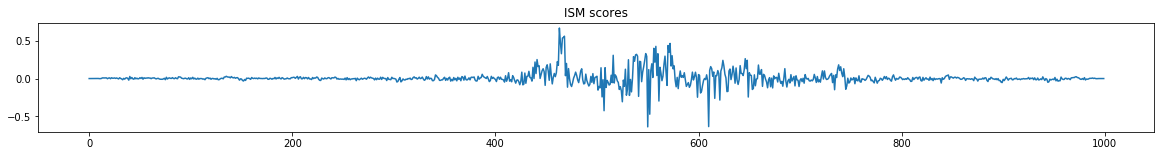

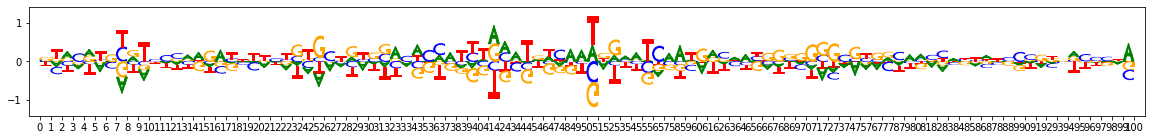

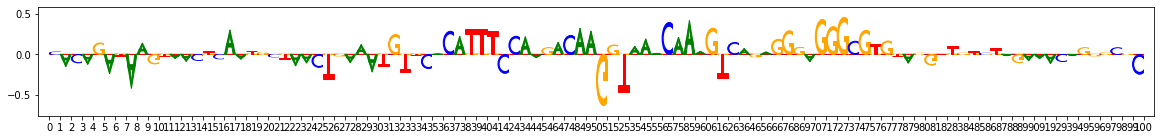

In [110]:
# BPNet
bin_index = 2998255  # Nanog
seq_slice = slice(500, 600)
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, show_sequences, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, show_sequences, seq_slice)